In [2]:
from crystalbuilder import *
import crystalbuilder.geometry as geo
import matplotlib.pyplot as plt
import numpy as np
import vedo

In [3]:
a1 = [1,0,0]
a2 = [0, 1 ,0]
a3 = [0, 0, 1]

a_mag = 1


geo_lattice = lattice.Lattice(a1, a2, a3, magnitude = [a_mag, a_mag, a_mag])


In [5]:
wyckoff_sites = [[1/8, 1/8, 1/8], #0
                 [3/8, 7/8, 5/8], #1
                 [7/8, 5/8, 3/8], #2
                 [5/8, 3/8, 7/8], #3
                 [5/8, 5/8, 5/8], #4
                 [7/8, 3/8, 1/8], #5
                 [3/8, 1/8, 7/8],  #6
                 [1/8, 7/8, 3/8], #7

                 [-1/8, 3/8, 1/8], #8
                 [3/8, 1/8, -1/8], #9
                 [1/8, -1/8, 3/8], #10
                 [5/8, 3/8, -1/8], #11
                 [3/8, -1/8, 5/8], #12
                 [-1/8, 5/8, 3/8] #13
                 ]

points = wyckoff_sites

In [6]:


radius = .01*a_mag


cylinders = [
    geo.Cylinder.from_vertices([points[0], points[9]], radius=radius),
    geo.Cylinder.from_vertices([points[0], points[8]], radius=radius),
    geo.Cylinder.from_vertices([points[0], points[10]], radius=radius),

    geo.Cylinder.from_vertices([points[1], points[7]], radius=radius),
    geo.Cylinder.from_vertices([points[1], points[4]], radius=radius),
    geo.Cylinder.from_vertices([points[4], points[3]], radius=radius),
    geo.Cylinder.from_vertices([points[4], points[2]], radius=radius),
    geo.Cylinder.from_vertices([points[2], points[5]], radius=radius),

    geo.Cylinder.from_vertices([points[12], points[6]], radius=radius),
    geo.Cylinder.from_vertices([points[3], points[6]], radius=radius),
    geo.Cylinder.from_vertices([points[7], points[13]], radius=radius),
    geo.Cylinder.from_vertices([points[11], points[5]], radius=radius),
]

spheres = [
    geo.Sphere(center=n, radius=radius) for n in wyckoff_sites[:8]
]


unit_cell = cylinders
sphere_cell = spheres

In [ ]:
a1_reps = 4
a2_reps = 4
a3_reps = 2
crystal = geo_lattice.tile_geogeometry(unit_cell, a1_reps, a2_reps, a3_reps)
crystal += geo_lattice.tile_geogeometry(sphere_cell, a1_reps, a2_reps, a3_reps)



In [11]:
scene = viewer.visualize(crystal, plotter_style=2)
scene.show(interactive=True).close()

objects = scene.get_meshes()

k=0
for obj in objects:
    k+=1
    string=f"srs1net/object-{k}.obj"
    vedo.write(obj, string)


TypeError: argument of type 'NoneType' is not iterable

In [7]:

import meep as mp
from meep import mpb

febid_n = 2.4
si_n = 3.5

febid_mat = mp.Medium(epsilon=(febid_n*febid_n))
si_mat = mp.Medium(epsilon=(si_n * si_n))

mpb_lattice = convert.to_mpb_lattice(geo_lattice)
core_geometry = convert.geo_to_mpb(unit_cell, material=febid_mat, lattice=mpb_lattice)


mpb_geometry = core_geometry

In [ ]:
vlist = [
    mp.Vector3(0, 0.5, 0.5),        # X
    mp.Vector3(0, 0.625, 0.375),    # U
    mp.Vector3(0, 0.5, 0),          # L
    mp.Vector3(0, 0, 0),            # Gamma
    mp.Vector3(0, 0.5, 0.5),        # X
    mp.Vector3(0.25, 0.75, 0.5),    # W
    mp.Vector3(0.375, 0.75, 0.375)  # K
]
k_corners = len(vlist)
k_points = mp.interpolate(3, vlist)
tick_labs = ['X', 'U', 'L', '$\Gamma$','X', 'W', 'K']


resolution = 48  # use a 16x16x16 grid
mesh_size = 2
num_bands = 10

ms = mpb.ModeSolver(
    geometry_lattice=mpb_lattice,
    k_points=k_points,
    geometry=mpb_geometry,
    resolution=resolution,
    num_bands=num_bands,
    mesh_size=mesh_size
)
ms.optimize_grid_size=True

ms.run()

Initializing eigensolver data
Computing 10 bands with 1e-07 tolerance
Working in 3 dimensions.
Grid size is 48 x 48 x 48.
Solving for 10 bands at a time.
Creating Maxwell data...
Mesh size is 2.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0.25,0.125,0)
          radius 0.05, height 0.353553, axis (0.707107, 0, -0.707107)
     cylinder, center = (0,0.25,0.125)
          radius 0.05, height 0.353553, axis (-0.707107, 0.707107, 0)
     cylinder, center = (0.125,0,0.25)
          radius 0.05, height 0.353553, axis (0, -0.707107, 0.707107)
     cylinder, center = (0.25,0.875,0.5)
          radius 0.05, height 0.353553, axis (-0.707107, 0, -0.707107)
     cylinder, center = (0.5,0.75,0.625)
          radius 0.05, height 0.353553, axis (0.707107, -0.707107, 0)
     cylinder, center = (0.625,0.5,0.75)
          radius 0.05, height 0

epsilon: 1-5.76, mean 2.1312, harm. mean 1.2649, 27.8754% > 1, 23.7648% "fill"
real part range: 1 .. 5.76


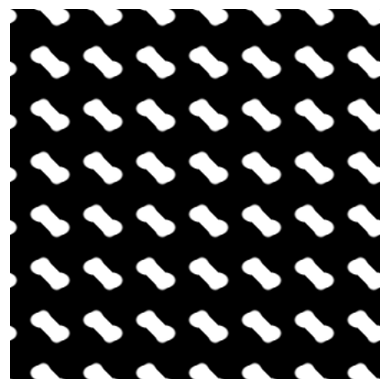

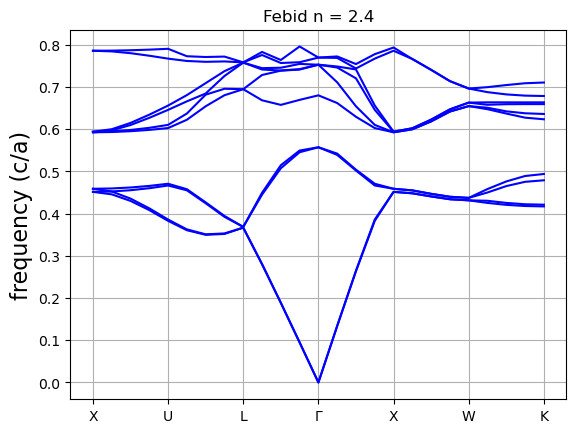

In [ ]:
### Plotting Dielectric Map ###
plt.figure()
md = mpb.MPBData(rectify=True, periods=7, resolution=64)
eps = ms.get_epsilon()
converted_eps = md.convert(eps)
layer_slice = 22
plt.imshow(converted_eps[:,:, layer_slice], interpolation='spline36', cmap='binary_r')
plt.axis('off')
plt.show()

### Plotting Band Structure ###
crysfreqs = ms.all_freqs
x = range(len(crysfreqs))
figgy = plt.figure()
plt.plot(x,crysfreqs, color='blue');
points_in_between = (len(crysfreqs)-1) / (k_corners-1)
tick_locs = [i*points_in_between for i in range(k_corners)]

plt.xticks(tick_locs,tick_labs)
plt.ylabel('frequency (c/a)', size=16)
plt.grid(True)
figax = plt.gca()
plt.title(f"Febid n = {febid_n}")

plt.show()
